# SMS Spam Detection

Note that I used https://www.geeksforgeeks.org/sms-spam-detection-using-tensorflow-in-python/ as a guide. I followed through this guide, but added some regularization techniques to the neural network.

This program classifies messages as 'ham' (non-spam messages) or 'spam' for spam messages. First, we load and organize the data.

In [2]:
import pandas as pd

# Read in data from csv
data = pd.read_csv("datasets/spam.csv", encoding='latin-1')

# Drop columns with NaN values
for col in data.columns:
    if 'Unnamed' in col:
        data.drop(columns=col, inplace=True)

# Rename columns to useful names
data = data.rename(columns={"v1":"Label", "v2":"Text"})

# Add an encoding for the labels: ham = 0, spam = 1
enc_labels = []
for item in data["Label"]:
    enc_labels.append(0 if item == "ham" else 1)
data.insert(loc=2, column="encoded_label", value=enc_labels)
print(data.head())


  Label                                               Text  encoded_label
0   ham  Go until jurong point, crazy.. Available only ...              0
1   ham                      Ok lar... Joking wif u oni...              0
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...              1
3   ham  U dun say so early hor... U c already then say...              0
4   ham  Nah I don't think he goes to usf, he lives aro...              0


We must find the average sentence length to help with padding during the model-building process.

In [3]:
# Find the average number of tokens in all sentences
sentences = data["Text"].values

avg_sentence_len = 0
for sentence in sentences:
    avg_sentence_len += len(sentence.split()) # adding the number of words in each sentence
avg_sentence_len = avg_sentence_len // len(sentences) # divide by the total number of sentences

Some words, such as "the", appear much more frequently than other words. We use a set to find the number of unique words to help with this imbalance.

In [4]:
# Find the total number of unique words
s = set()
for sentence in sentences:
    for word in sentence.split():
        s.add(word)
num_unique_words = len(s)
print(num_unique_words)

15585


We split the data using an 80/20 split. The must use the encoded labels instead of 'ham' or 'spam' since our model cannot use strings for its computations.

In [5]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(data["Text"], data["encoded_label"], train_size=0.8, random_state=42)

Now, we create the model. Since the model is not exactly sequential, we use the functional API. The model was overfitting the data (it acheived almost 100% accuracy), so I added some dropout layers and regularization. These constraints decrease the model's likeliness of overfitting.

In [6]:
import tensorflow as tf

text_vec = tf.keras.layers.TextVectorization(max_tokens=num_unique_words, standardize="lower_and_strip_punctuation", 
                                       output_sequence_length=avg_sentence_len, output_mode="int")
text_vec.adapt(X_train)
embed_layer = tf.keras.layers.Embedding(input_dim=num_unique_words, output_dim=128, input_length=avg_sentence_len,
                                        embeddings_initializer="uniform")

input_layer = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer = embed_layer(vec_layer)
x = tf.keras.layers.GlobalAveragePooling1D()(embedding_layer)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = tf.keras.layers.Dropout(0.5)(x)
output_layer = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=5)




Epoch 1/5

140/140 [==============================] - 9s 39ms/step - loss: 0.4058 - accuracy: 0.8580
Epoch 2/5
140/140 [==============================] - 5s 35ms/step - loss: 0.1826 - accuracy: 0.9345
Epoch 3/5
140/140 [==============================] - 5s 36ms/step - loss: 0.1070 - accuracy: 0.9776
Epoch 4/5
140/140 [==============================] - 5s 36ms/step - loss: 0.0713 - accuracy: 0.9847
Epoch 5/5
140/140 [==============================] - 5s 36ms/step - loss: 0.0530 - accuracy: 0.9899
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding (Embeddi

We should not use accuracy as our only metric. We can compute the f1 score, which gives us a much more accurate representation of the model's performance.

In [10]:
# print(model.summary())

y_pred = model.predict(X_test)
y_pred = y_pred.round()

y_pred1D = []
for i in range(len(y_pred)):
    y_pred1D.append(y_pred[i][0])

y_pred1D = pd.Series(y_pred1D)

# print(y_pred1D.values)

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print("Accuracy:", accuracy_score(y_pred=y_pred1D, y_true=y_test))
print("Precision:", precision_score(y_pred=y_pred1D, y_true=y_test))
print("Recall:", recall_score(y_pred=y_pred1D, y_true=y_test))
print("F1:", f1_score(y_pred=y_pred1D, y_true=y_test))


35/35 [==============================] - 0s 4ms/step
[1. 0. 1. ... 0. 0. 1.]
Accuracy: 0.9748878923766816
Precision: 0.9295774647887324
Recall: 0.88
F1: 0.9041095890410958


Lastly, we make a confusion matrix to analyze the number of correct and incorrect predictions. It seems that most of the predictions were true positives and true negatives.

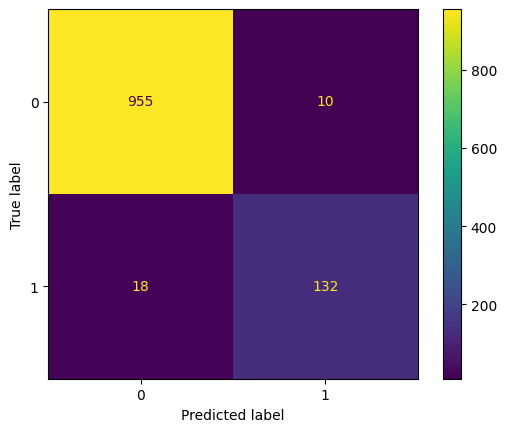

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cf_matrx = confusion_matrix(y_pred=y_pred1D, y_true=y_test)
ConfusionMatrixDisplay(cf_matrx).plot()